# Digit Recognition using Convolutional Neural Network

Heavily inspired by Yassine Ghouzam's Notebook

Link to Notebook: https://www.kaggle.com/code/yassineghouzam/introduction-to-cnn-keras-0-997-top-6#3.-CNN

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

np.random.seed(2)

import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical # one-hot encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.optimizers import RMSprop

sns.set(style='white', context='notebook', palette='deep')


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [2]:
train = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
test = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')
sample = pd.read_csv('/kaggle/input/digit-recognizer/sample_submission.csv')

## Data Representation

In [3]:
X_train = train.drop(['label'], axis = 1)
y_train = train['label']

# Count numbers
y_train.value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

In [4]:
# Check if there's no nulls
print(X_train.isnull().sum().sum() == 0)
print(y_train.isnull().sum().sum() == 0)

X_train.info()

True
True
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 784 entries, pixel0 to pixel783
dtypes: int64(784)
memory usage: 251.2 MB


## Data Preprocessing

In [5]:
X_train = X_train / 255.0
test = test / 255.0

#Normalization

In [6]:
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

# if image is RGB then set dims to 28 28 3

In [7]:
y_train = to_categorical(y_train, num_classes = 10)

In [8]:
random_seed = 2
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = random_seed)

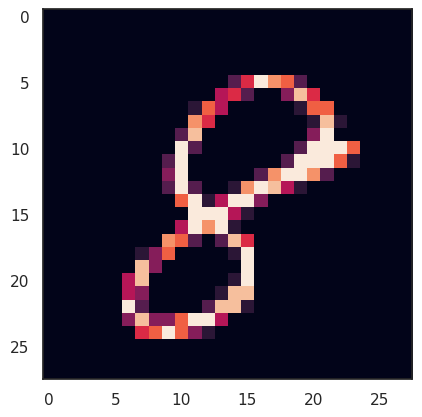

In [9]:
eg = plt.imshow(X_train[0][:,:,0])

## Defining model

In [10]:
model = Sequential([
    Conv2D(filters=64, kernel_size=(5, 5), padding='Same', activation='relu', input_shape=(28, 28, 1)),
    BatchNormalization(),
    Conv2D(filters=64, kernel_size=(5, 5), padding='Same', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(filters=64, kernel_size=(3, 3), padding='Same', activation='relu'),
    BatchNormalization(),
    Conv2D(filters=64, kernel_size=(3, 3), padding='Same', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
    Dropout(0.25),

    Conv2D(filters=64, kernel_size=(3, 3), padding='Same',  activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(10, activation ='softmax'),
])

loss = 'categorical_crossentropy'
optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
metrics = ['accuracy']

model.compile(optimizer = optimizer, loss = loss, metrics = metrics)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=2, 
                                            verbose=2, 
                                            factor=0.5, 
                                            min_lr=0.00001
)

early_stopping = EarlyStopping(monitor='val_loss',
                              patience=5,
                              verbose=0,
                              restore_best_weights=True)

model.fit(X_train, y_train,
          batch_size = 86,
          epochs = 1, #change this after submitting
          validation_data = (X_val, y_val),
          callbacks = [learning_rate_reduction, early_stopping],
         )


2023-07-26 03:23:27.067318: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


440/440 [==============================] - 18s 19ms/step - loss: 0.1511 - accuracy: 0.9520 - val_loss: 0.1047 - val_accuracy: 0.9686 - lr: 0.0010


## Data Augmentation

In [11]:
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=10,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False)

datagen.fit(X_train)

history = model.fit(datagen.flow(X_train, y_train, batch_size = 86),
                   epochs = 30,
                   validation_data = (X_val, y_val),
                   callbacks = [learning_rate_reduction, early_stopping],
                   steps_per_epoch = X_train.shape[0] // 86)

Epoch 1/30


2023-07-26 03:23:45.029999: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


439/439 [==============================] - 19s 40ms/step - loss: 0.1212 - accuracy: 0.9619 - val_loss: 0.0385 - val_accuracy: 0.9881 - lr: 0.0010
Epoch 2/30
439/439 [==============================] - 17s 38ms/step - loss: 0.0757 - accuracy: 0.9769 - val_loss: 0.0308 - val_accuracy: 0.9900 - lr: 0.0010
Epoch 3/30
439/439 [==============================] - 17s 40ms/step - loss: 0.0591 - accuracy: 0.9813 - val_loss: 0.0279 - val_accuracy: 0.9917 - lr: 0.0010
Epoch 4/30
439/439 [==============================] - 17s 39ms/step - loss: 0.0503 - accuracy: 0.9848 - val_loss: 0.0306 - val_accuracy: 0.9905 - lr: 0.0010
Epoch 5/30
439/439 [==============================] - 17s 38ms/step - loss: 0.0471 - accuracy: 0.9858 - val_loss: 0.0169 - val_accuracy: 0.9940 - lr: 0.0010
Epoch 6/30
439/439 [==============================] - 17s 40ms/step - loss: 0.0444 - accuracy: 0.9868 - val_loss: 0.0293 - val_accuracy: 0.9905 - lr: 0.0010
Epoch 7/30
438/439 [============================>.] - ETA: 0s - loss:

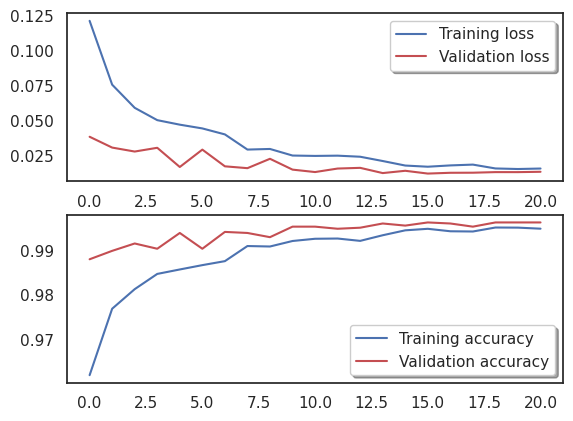

In [12]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

## Submit data (Kaggle)

In [13]:
results = model.predict(test)
results = np.argmax(results, axis=1)
results = pd.Series(results, name="Label")

submission = pd.concat([pd.Series(range(1,28001), name = "ImageId"), results], axis = 1)

submission.to_csv("cnn_digit_recognition.csv", index = False)

875/875 [==============================] - 2s 3ms/step
